Script to plot the reflection, transmission and absorption of a twisted polaritonic crystal (PC) on an in-plane anisotropic material (MoO3 as example). The derivations are based on thin layer approximation.

# Open the packages for the script

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec

In [2]:
# Define some useful functions for the code
cos = np.cos
sin = np.sin
pi = np.pi
sqrt = np.sqrt
bessel = spec.jv

## Define the function of the permittivity of MoO3
Parameters from paper: https://onlinelibrary.wiley.com/doi/abs/10.1002/adma.201908176

In [3]:
def eps_harm_Osc(w, wT, wL, gamma):
    eps_h = (w*w-wL**2+1j*gamma*w)/(w*w-wT**2+1j*gamma*w)
    return eps_h

In [4]:
def eps_MoO3(w, axis):
    if(axis=='[100]'): # x-axis of MoO3
        epsinf = 6.09
        gamma = np.array([[73, 11.9, 2.1]])
        wTO = np.array([[507, 822.7, 998.8]])
        wLO = np.array([[534, 978.8, 999.5]])

    if(axis=='[001]'): # z-axis of MoO3
        epsinf = 6.38
        gamma = np.array([[17.9]])
        wTO = np.array([[544.9]])
        wLO = np.array([[855.8]])

    if(axis=='[010]'): # y-axis of MoO3
        epsinf = 4.4
        gamma = np.array([[0.7]])
        wTO = np.array([[963]])
        wLO = np.array([[1006.6]])

    eps = np.ones(np.shape(w)[0],)
    for i in range(np.shape(wTO)[1]):
        eps = eps*eps_harm_Osc(w,wTO[0,i],wLO[0,i],gamma[0,i])

    eps = epsinf*eps

    return eps

# Define T coefficient
Expressions from the book: https://www.worldscientific.com/doi/abs/10.1142/9789813228726_0008
Eq (8.24)

In [5]:
def Tcoefficient(kt,k0,g1t,g2t,n1,n2,e1,e2,Tn):
    # Function to calculate T coefficient from Tn terms
    
    Ln1 = len(n1)
    Ln2 = len(n2)
    T = 0

    for i in range(Ln1):
        for j in range(Ln2):

            # In plane wavenumber
            ktN = kt+n1[i]*g1+n2[j]*g2
            # Calculate out of plane momentum
            q1z = sqrt(e1*k0**2-np.vdot(kt,kt))/k0
            q2zN = sqrt(e2*k0**2-np.vdot(ktN,ktN))/k0

            # Ensure q1z has positive imaginary part (losses)
            if (np.imag(q1z)<0):
                q1z = -q1z
            if (np.imag(q2zN)<0):
                q2zN = -q2zN
            
            for b2 in range(2):
                if (b2==1): # p-polarization
                    T = T+np.real(q1z*e2/(q2zN*e1))*np.abs(Tn[2*Ln2*i+2*j+b2,0])**2
                else:
                    T = T+np.real(q2zN/q1z)*np.abs(Tn[2*Ln2*i+2*j+b2,0])**2
    return T

# Define D matrix
Formula from the article: https://onlinelibrary.wiley.com/doi/abs/10.1002/lpor.202200428

In [6]:
def HA_Dmatrix(kt,k0,g1t,g2t,n1,n2,e1,e2,axxr,axyr,ayyr):
    # Function to calculate the D matrix of the PC

    #Initialize
    Ln1 = len(n1)
    Ln2 = len(n2)
    [c1,c2] = np.shape(axxr)
    D = np.zeros((2*Ln1*Ln2,2*Ln1*Ln2))+0*1j

    for i in range(Ln1):
        for j in range(Ln2):

            # In-plane wavenumber row
            ktN2 = kt+n1[i]*g1t+n2[j]*g2t
            
            for b2 in range(2):
                for k in range(Ln1):
                    for l in range(Ln2):

                        # In plane wavenumber column
                        ktN1 = kt+n1[k]*g1t+n2[l]*g2t
                        
                        # Out-of-plane momentum
                        qz1N = sqrt(e1*k0**2-np.vdot(ktN1,ktN1))/k0
                        qz2N = sqrt(e2*k0**2-np.vdot(ktN1,ktN1))/k0

                        # Ensure that imag(qz)>0
                        if (np.imag(qz1N)<0):
                            qz1N = -qz1N
                        
                        if (np.imag(qz2N)<0):
                            qz2N = -qz2N
                        
                        #Matrix elements

                        for b1 in range(2):
                            P = 0+0*1j
                            M = 0+0*1j
                            
                            if np.abs(n1[i]-n1[k])<=c1-1 and np.abs(n2[j]-n2[l])<=c2-1:
                                
                                # M^{b2,b1}_{N''N}
                                if b1==0 and b2==0:
                                    M = axxr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,1]*ktN2[0,1]-axyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*(ktN1[0,1]*ktN2[0,0]+ktN1[0,0]*ktN2[0,1])+ayyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,0]*ktN2[0,0]
                                elif b1==1 and b2==0:
                                    M = -axxr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,0]*ktN2[0,1]+axyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*(ktN1[0,0]*ktN2[0,0]-ktN1[0,1]*ktN2[0,1])+ayyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,1]*ktN2[0,0]
                                elif b1==0 and b2==1:
                                    M = -axxr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,1]*ktN2[0,0]+axyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*(ktN1[0,0]*ktN2[0,0]-ktN1[0,1]*ktN2[0,1])+ayyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,0]*ktN2[0,1]
                                elif b1==1 and b2==1:
                                    M = axxr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,0]*ktN2[0,0]+axyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*(ktN1[0,1]*ktN2[0,0]+ktN1[0,0]*ktN2[0,1])+ayyr[int(np.abs(n1[i]-n1[k])),int(np.abs(n2[j]-n2[l]))]*ktN1[0,1]*ktN2[0,1]

                                
                                # Diagonal elements have an extra term
                                if n2[j]==n2[l] and n1[i]==n1[k] and b1==b2:
                                    if(b1==0):
                                        P = qz1N+qz2N
                                    elif(b1==1):
                                        P = e1/qz1N+e2/qz2N
                                
                                # To avoid some 1/0

                                if(M==0):
                                    D[2*Ln2*i+2*j+b2,2*Ln2*k+2*l+b1] = P
                                else:
                                    D[2*Ln2*i+2*j+b2,2*Ln2*k+2*l+b1] = 2*M/(np.linalg.norm(ktN1)*np.linalg.norm(ktN2))+P
                                    

    return D


# Calculate the reciprocal lattice

In [7]:
# Inputs:
L = 0.9 # Modulus of the vector basis for hole array in um
mn1 = 25 # nº of harmonics to plot in the L1 direction
mn2 = 25 # nº of harmonics to plot in the L2 direction
d = 0.4/2 # Radius of the holes in um

# Calculate the lattice vectors (square lattice, for another lattice change the vectors)
L1 = np.array([[L,0]])
L2 = np.array([[0,L]])
Ln1 = 2*mn1+1 # Number of harmonics in L1 direction
Ln2 = 2*mn2+1 # Number of harmonics in L2 direction
n1 = np.linspace(-mn1,mn1,int(Ln1)) # Harmonics in L1 direction
n2 = np.linspace(-mn2,mn2,int(Ln2)) # Harmonics in L2 direction

# Reciprocal vector basis
g1 = np.array([[2*pi/L1[0,0],-2*pi*L2[0,0]/(L2[0,1]*L1[0,0])]])
g2 = np.array([[0,2*pi/L2[0,1]]])

# Fourier expansion coefficients without conductivity
fen = mn1+1 # fen=mn1+1 to take all possible harmonics
fem = mn2+1 # fem=mn2+1 to take all possible harmonics
FE = np.zeros((fen,fem))

for i in range(fen):
    for j in range(fem):
        if((i==0)&(j==0)):
            FE[i,j]=(1-pi*d**2/L**2)
        else:
            FE[i,j]=-d/(L*sqrt(i**2+j**2))*bessel(1,2*pi*d/L*sqrt(i**2+j**2))

# Calculate the reflection and transmission
Formula from the article: https://onlinelibrary.wiley.com/doi/abs/10.1002/lpor.202200428

In [8]:
# Inputs:
w = np.array([[861.6,870.4,894]]) # Frequency in cm^-1
[empty,nw] = np.shape(w)
e2 = 1 # Permittivity of the substrate
e1 = 1 # Permittivity of the superstrate
t = 0.1 # Thickness of the layer, in um
theta = 0 # Twist angle
I = np.array([[0,1]]) # Incident field as a vector, I=[Is,Ip]
kt = np.array([[1,0]])*10e-14+0*1j # Momentum of the incident wave. Normal incidence linearly polarized along x direction

# Script:

# Permittivity of the material
epsx = eps_MoO3(w, '[100]')
epsy = eps_MoO3(w, '[001]')

# Initialization of T and R
T = np.zeros((nw,fen))

# Twisted reciprocal vector basis
g1t = np.array([[g1[0,0]*cos(theta)-g1[0,1]*sin(theta),g1[0,0]*sin(theta)+g1[0,1]*cos(theta)]])
g2t = np.array([[g2[0,0]*cos(theta)-g2[0,1]*sin(theta),g2[0,0]*sin(theta)+g2[0,1]*cos(theta)]])

for h in range(nw):
    
    # Momentum and wavelength
    lam = 10**4/w[0,h]
    k0 = 2*pi/lam
        
    # Effective conductivity
    ax = pi*t/(1j*lam)*epsx[0,h]
    ay = pi*t/(1j*lam)*epsy[0,h]

    for k in range(mn1+1):
        
        # Fourier expansion conductivity
        ayyr = ay*FE[0:k+1,0:k+1]
        axyr = 0*FE[0:k+1,0:k+1]
        axxr = ax*FE[0:k+1,0:k+1]

        # Initialization of the system of equations
        V = np.zeros((2*(2*k+1)**2,1))+0*1j

        # Calculate out of plane momentum
        q1z = sqrt(e1*k0**2-np.vdot(kt,kt))/k0
        
        # Ensure q1z has positive imaginary part (losses)
        if (np.imag(q1z)<0):
            q1z = -q1z
        
        n1k = np.linspace(-k,k,int(2*k+1))
        n2k = np.linspace(-k,k,int(2*k+1))

        # Matrix of the system of equations
        D = HA_Dmatrix(kt,k0,g1t,g2t,n1k,n2k,e1,e2,axxr,axyr,ayyr)
        
        # Vector with the dependent variables of the system of equations
        V[(2*k)**2]=2*I[0,0]*q1z # s polariz for (0,0) harmonic
        V[(2*k)**2+1]=2*I[0,1]*e1/q1z # p polariz for (0,0) harmonic
        
        # Solve Tn
        Tn = np.linalg. solve(D,V)
        
        # Obtain R and T for each frequency
        T[h,k] = Tcoefficient(kt,k0,g1t,g2t,n1k,n2k,e1,e2,Tn)


KeyboardInterrupt: 

# Plot the results

Text(0.5, 0, 'nº of harmoncis')

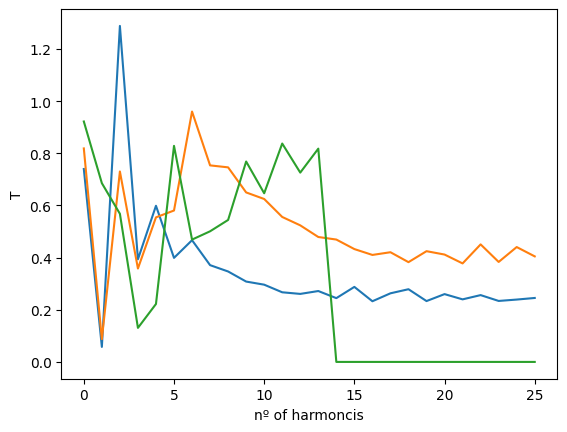

In [9]:
n1p = np.linspace(0,mn1,int(mn1+1))

for h in range(nw):
    plt.plot(n1p,T[h,:])

plt.ylabel("T")
plt.xlabel("nº of harmoncis")